In [14]:
from glob import glob
from astroquery.mast import Mast, Observations
import os
import shutil
import pyavm
import numpy as np
import PIL
import json
import requests
import asdf
import regions
from astropy import log
from astropy.io import ascii, fits
from astropy.wcs import WCS
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.utils.data import download_file
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch, LinearStretch
from astropy.visualization import simple_norm
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table
from astropy.nddata import Cutout2D
import astropy.units as u

In [15]:
basepath = '/orange/adamginsburg/jwst/cloudc/'

In [16]:
ref_tbl = Table.read(f'{basepath}/catalogs/crowdsource_based_nircam-f405n_reference_astrometric_catalog_truncated10000.ecsv')
crds_ref = ref_tbl['skycoord']

In [17]:
vvvcat = Table.read('/orange/adamginsburg/jwst/cloudc/catalogs/jw02221-o002_t001_nircam_clear-f405n-merged_vvvcat.fits')
crds_vvv = SkyCoord(vvvcat['RAJ2000'].quantity, vvvcat['DEJ2000'].quantity, frame='fk5')

In [19]:
cd /orange/adamginsburg/jwst/cloudc/analysis/

/blue/adamginsburg/adamginsburg/jwst/cloudc/code/brick-jwst-2221/analysis


In [20]:
%run selections.py

/blue/adamginsburg/adamginsburg/jwst/cloudc/code/brick-jwst-2221/analysis/selections.py:23: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
/blue/adamginsburg/adamginsburg/jwst/cloudc/code/brick-jwst-2221/analysis/selections.py:23: DeprecationWarning: `photutils.EPSFBuilder` is a deprecated alias for `photutils.psf.EPSFBuilder` and will be removed in the future. Instead, please use `from photutils.psf import EPSFBuilder` to silence this warning.
  from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
/blue/adamginsburg/adamginsburg/jwst/cloudc/code/brick-jwst-2221/analysis/selections.py:23: DeprecationWarning: `photutils.find_peaks` is a deprecated alias for `photutils.detection.find_pe

Selecting module merged

NRCA
3798 saturated in near_saturated_f212n_f212n
528 saturated in near_saturated_f466n_f466n
1382 saturated in near_saturated_f405n_f405n
3317 saturated in near_saturated_f187n_f187n
5742 saturated in near_saturated_f182m_f182m
11128 near saturated out of 568994.  That leaves 557866 not near unsaturated
225 saturated in replaced_saturated_f212n
53 saturated in replaced_saturated_f466n
147 saturated in replaced_saturated_f405n
413 saturated in replaced_saturated_f187n
517 saturated in replaced_saturated_f182m
1252 saturated out of 568994.  That leaves 567742 unsaturated
Filter f410m has qf=117890, spread=99442, fracflux=10178 ok, totaling 9965.  There are 568994 total, of which 470886 are masked and 98108 are unmasked. qfmasksum=450489, inverse=118505.
Filter f212n has qf=370798, spread=371805, fracflux=238730 ok, totaling 238176.  There are 568994 total, of which 197272 are masked and 371722 are unmasked. qfmasksum=197099, inverse=371895.
Filter f466n has qf=2

# Comparing Refcat and VVV

In [6]:
idx, sidx, sep, _ = crds_ref.search_around_sky(crds_vvv, 0.2*u.arcsec)
print(len(idx))

2697


In [7]:
dra = (crds_ref[sidx].ra - crds_vvv[idx].ra).to(u.arcsec)
ddec = (crds_ref[sidx].dec - crds_vvv[idx].dec).to(u.arcsec)

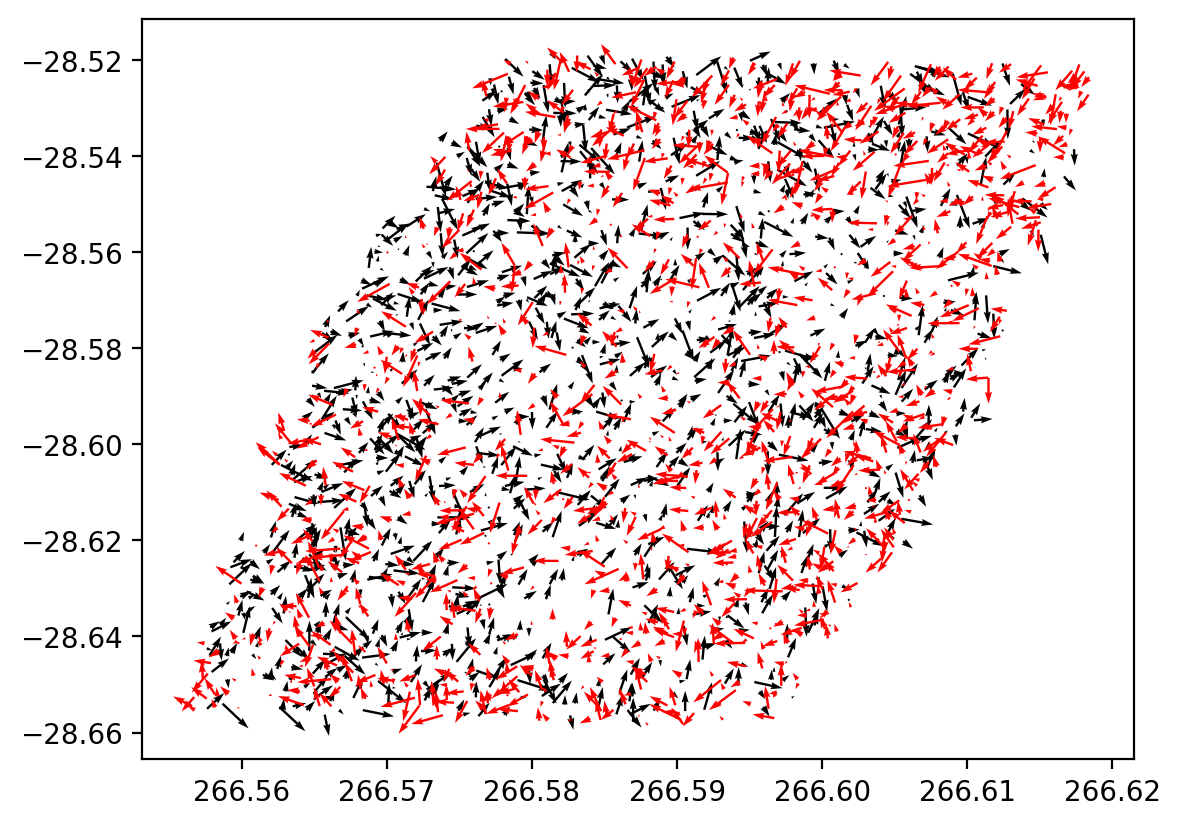

In [9]:
plt.figure(dpi=200)
plt.quiver(crds_ref[sidx][dra>0].ra.value, crds_ref[sidx][dra>0].dec.value, dra.to(u.arcsec).value[dra>0], ddec.to(u.arcsec).value[dra>0])
plt.quiver(crds_ref[sidx][dra<0].ra.value, crds_ref[sidx][dra<0].dec.value, dra.to(u.arcsec).value[dra<0], ddec.to(u.arcsec).value[dra<0], color='r')

(array([ 25.,  61., 132., 230., 467., 717., 586., 306., 126.,  47.]),
 array([-0.25179369, -0.20741922, -0.16304476, -0.1186703 , -0.07429583,
        -0.02992137,  0.0144531 ,  0.05882756,  0.10320203,  0.14757649,
         0.19195095]),
 <BarContainer object of 10 artists>)

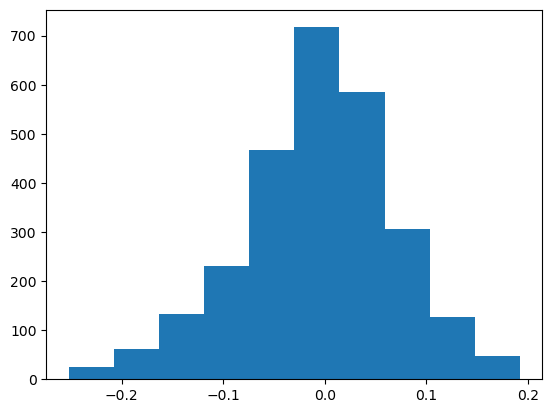

In [10]:
plt.hist(dra)

(array([ 33.,  81., 168., 296., 489., 567., 504., 335., 165.,  59.]),
 array([-0.21429646, -0.17510035, -0.13590424, -0.09670813, -0.05751202,
        -0.01831591,  0.0208802 ,  0.06007631,  0.09927242,  0.13846853,
         0.17766464]),
 <BarContainer object of 10 artists>)

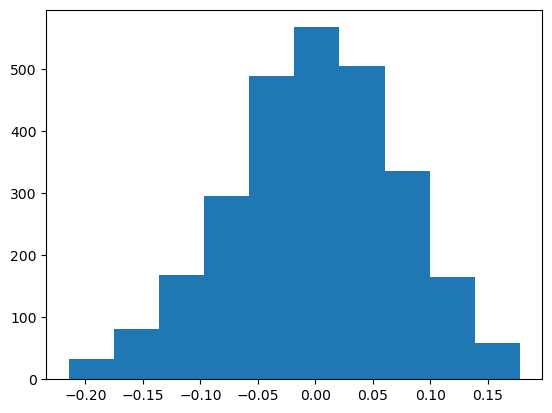

In [11]:
plt.hist(ddec)

# Basetable Comparisons with Refcoords

In [22]:
basetable.columns

<TableColumns names=('skycoord_ref','skycoord_ref_filtername','sep_f410m','id_f410m','skycoord_f410m','x_f410m','y_f410m','flux_f410m','passno_f410m','dx_f410m','dy_f410m','dflux_f410m','qf_f410m','rchi2_f410m','fracflux_f410m','fluxlbs_f410m','dfluxlbs_f410m','fwhm_f410m','spread_model_f410m','dspread_model_f410m','fluxiso_f410m','xiso_f410m','yiso_f410m','flags_f410m','sky_f410m','mask_f410m','flux_jy_f410m','eflux_jy_f410m','mag_ab_f410m','emag_ab_f410m','near_saturated_f410m_f410m','replaced_saturated_f410m','sep_f212n','id_f212n','skycoord_f212n','x_f212n','y_f212n','flux_f212n','passno_f212n','dx_f212n','dy_f212n','dflux_f212n','qf_f212n','rchi2_f212n','fracflux_f212n','fluxlbs_f212n','dfluxlbs_f212n','fwhm_f212n','spread_model_f212n','dspread_model_f212n','fluxiso_f212n','xiso_f212n','yiso_f212n','flags_f212n','sky_f212n','mask_f212n','flux_jy_f212n','eflux_jy_f212n','mag_ab_f212n','emag_ab_f212n','near_saturated_f212n_f212n','replaced_saturated_f212n','sep_f466n','id_f466n','sk

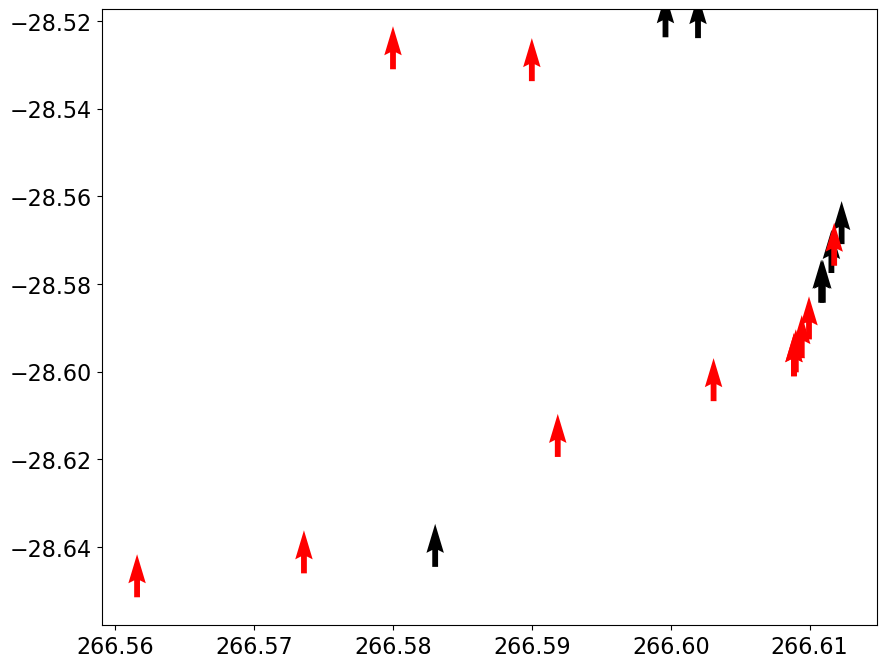

In [28]:
tbl_uses = basetable[basetable['good_f405n']]
quiv_x = tbl_uses['skycoord_ref'].ra
quiv_y = tbl_uses['skycoord_ref'].dec
quiv_u = quiv_x - tbl_uses['skycoord_f405n'].ra
quiv_v = quiv_x - tbl_uses['skycoord_f405n'].dec

#plt.quiver(crds_ref[sidx][dra>0].ra.value, crds_ref[sidx][dra>0].dec.value, dra.to(u.arcsec).value[dra>0], ddec.to(u.arcsec).value[dra>0])
#plt.quiver(crds_ref[sidx][dra<0].ra.value, crds_ref[sidx][dra<0].dec.value, dra.to(u.arcsec).value[dra<0], ddec.to(u.arcsec).value[dra<0], color='r')
plt.quiver(quiv_x[quiv_u>0].value, quiv_y[quiv_u>0].value, quiv_u.to(u.arcsec)[quiv_u>0].value, quiv_v.to(u.arcsec)[quiv_u>0].value)
plt.quiver(quiv_x[quiv_u<0].value, quiv_y[quiv_u<0].value, quiv_u.to(u.arcsec)[quiv_u<0].value, quiv_v.to(u.arcsec)[quiv_u<0].value, color='r')